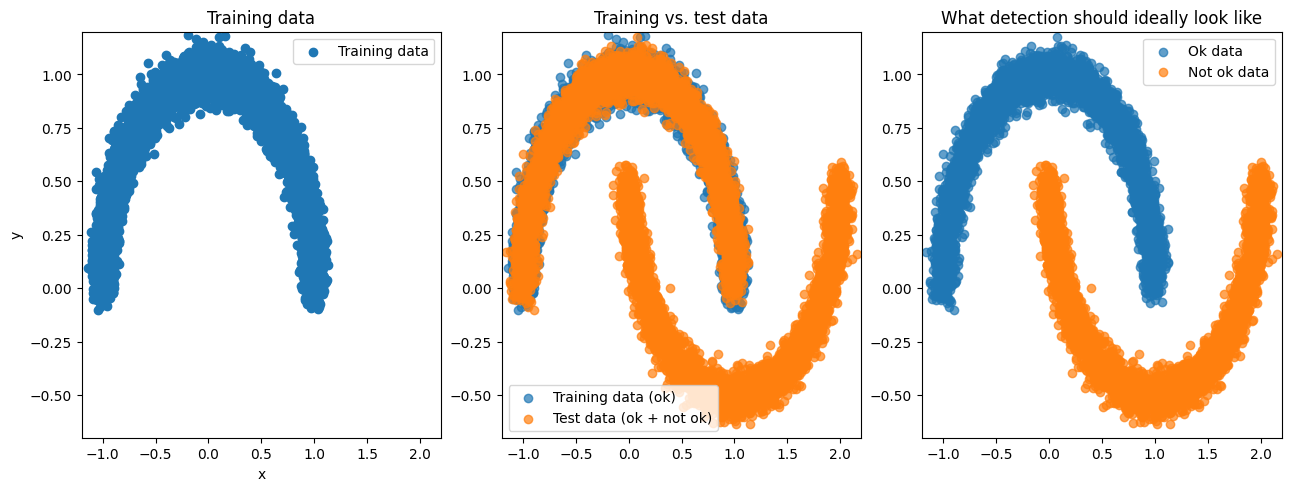

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import DBSCAN

from iav_flap_anomaly_detection import make_data, plot_data
X_train, X_test, test_ground_truth = make_data()

plot_data(X_train, X_test, test_ground_truth)

In [2]:
def evaluate_model(y_true, y_pred, model_name):
    # Convert predictions to binary labels compatible with ground truth
    # Most models use: 1 for inliers, -1 for outliers
    # Convert to match test_ground_truth: 1 for normal, -1 for anomaly
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    
    print(f"{model_name} Classification Report:")
    print(classification_report(y_true, y_pred))
    
    print(f"{model_name} Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\n")
    
    return accuracy

# Try multiple models

# 1. Isolation Forest
print("Training Isolation Forest...")
iso_forest = IsolationForest(random_state=42, contamination='auto')
iso_forest.fit(X_train)  # Training on normal data only
iso_forest_preds = iso_forest.predict(X_test)
iso_forest_accuracy = evaluate_model(test_ground_truth, iso_forest_preds, "Isolation Forest")

# 2. One-Class SVM
print("Training One-Class SVM...")
ocsvm = OneClassSVM(gamma='auto', nu=0.1)
ocsvm.fit(X_train)  # Training on normal data only
ocsvm_preds = ocsvm.predict(X_test)
ocsvm_accuracy = evaluate_model(test_ground_truth, ocsvm_preds, "One-Class SVM")

# 3. Local Outlier Factor
print("Training Local Outlier Factor...")
lof = LocalOutlierFactor(novelty=True, contamination=0.1)
lof.fit(X_train)  # Training on normal data only
lof_preds = lof.predict(X_test)
lof_accuracy = evaluate_model(test_ground_truth, lof_preds, "Local Outlier Factor")

# Model 4: DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
dbscan = DBSCAN(eps=0.3, min_samples=10)
y_pred_dbscan = dbscan.fit_predict(X_test)
# Convert DBSCAN predictions: 0 (core points) and positive integers (cluster labels) to 1 (normal), and -1 (noise) to -1 (anomaly)
y_pred_dbscan_binary = np.where(y_pred_dbscan == -1, -1, 1)

Training Isolation Forest...
Isolation Forest Accuracy: 0.7672
Isolation Forest Classification Report:
              precision    recall  f1-score   support

          -1       0.68      1.00      0.81      5000
           1       1.00      0.53      0.70      5000

    accuracy                           0.77     10000
   macro avg       0.84      0.77      0.75     10000
weighted avg       0.84      0.77      0.75     10000

Isolation Forest Confusion Matrix:
[[5000    0]
 [2328 2672]]


Training One-Class SVM...
One-Class SVM Accuracy: 0.8139
One-Class SVM Classification Report:
              precision    recall  f1-score   support

          -1       0.87      0.73      0.80      5000
           1       0.77      0.89      0.83      5000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000

One-Class SVM Confusion Matrix:
[[3670 1330]
 [ 531 4469]]


Training Local Outlier F

In [5]:
dbscan_accuracy = accuracy_score(test_ground_truth, y_pred_dbscan_binary)

results = {
    "Isolation Forest": {"accuracy": iso_forest_accuracy, "predictions": iso_forest_preds},
    "One-Class SVM": {"accuracy": ocsvm_accuracy, "predictions": ocsvm_preds},
    "Local Outlier Factor": {"accuracy": lof_accuracy, "predictions": lof_preds},
    "DBSCAN": {"accuracy": dbscan_accuracy, "predictions": y_pred_dbscan_binary}
}

best_model_name = max(results, key=lambda x: results[x]["accuracy"])
best_accuracy = results[best_model_name]["accuracy"]
best_predictions = results[best_model_name]["predictions"]

print(f"\nPerformance Summary:")
for model, data in results.items():
    print(f"{model}: {data['accuracy']:.4f}")

print(f"\nBest performing model: {best_model_name} with accuracy: {best_accuracy:.4f}")


Performance Summary:
Isolation Forest: 0.7672
One-Class SVM: 0.8139
Local Outlier Factor: 0.9462
DBSCAN: 0.5000

Best performing model: Local Outlier Factor with accuracy: 0.9462


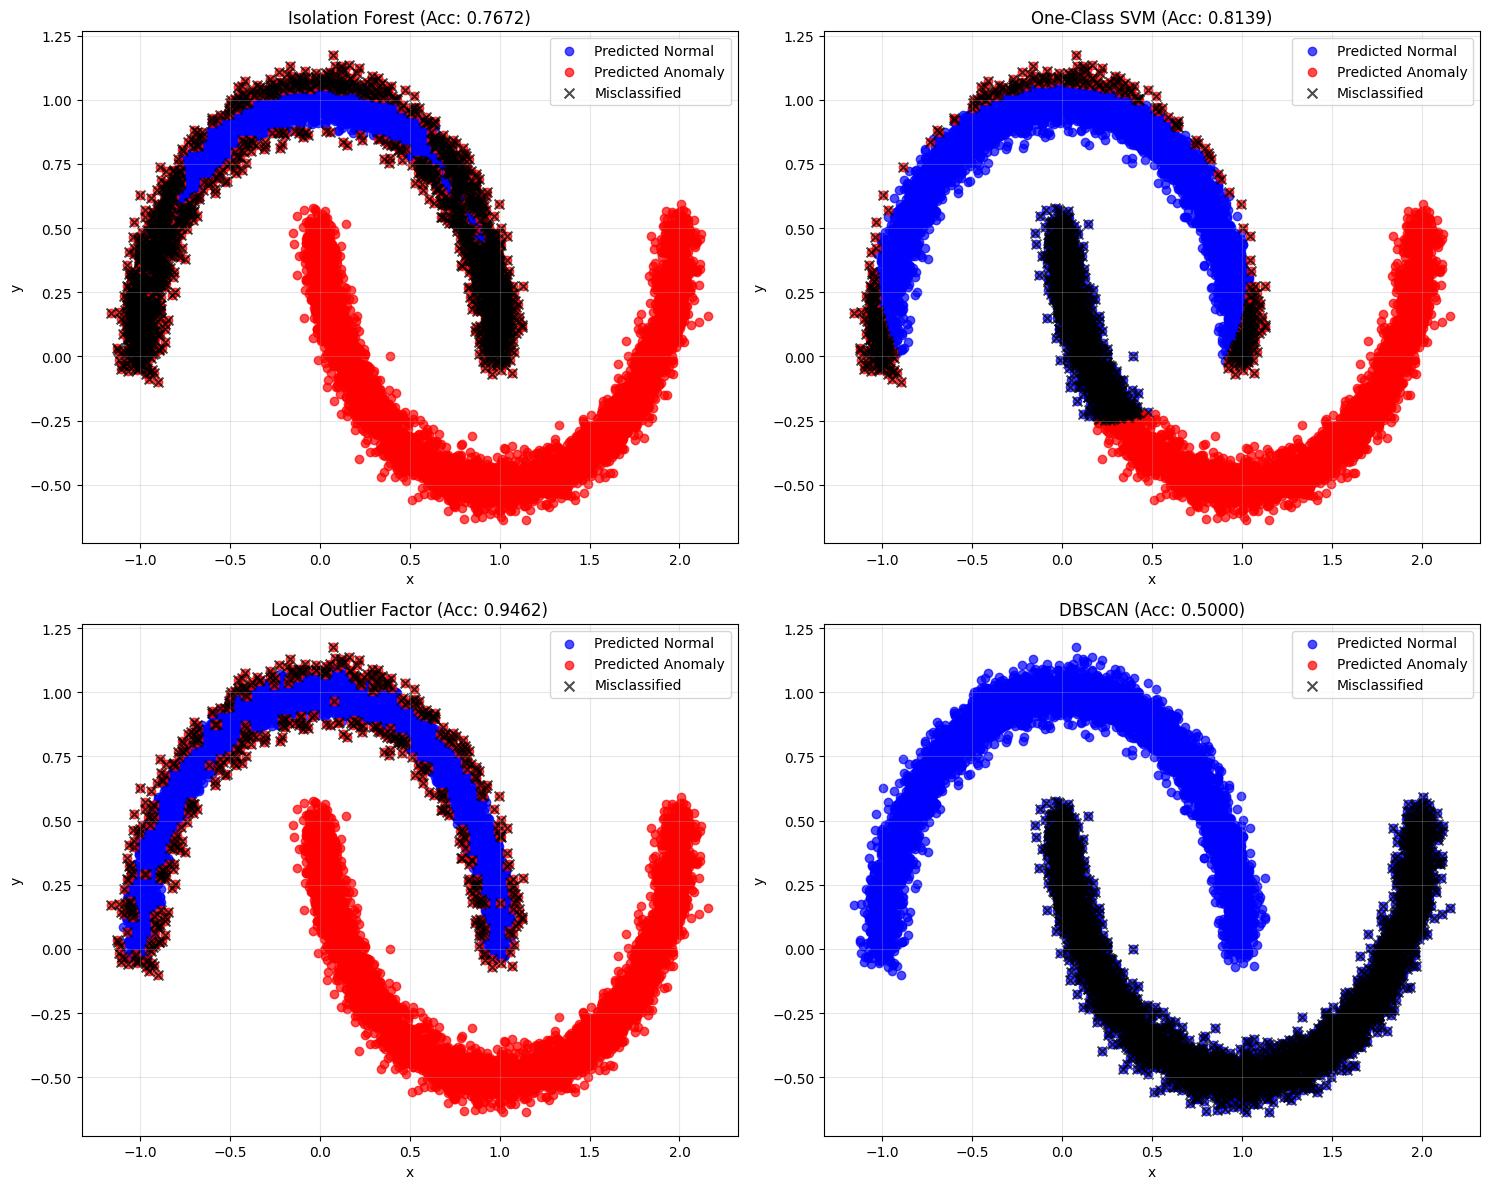

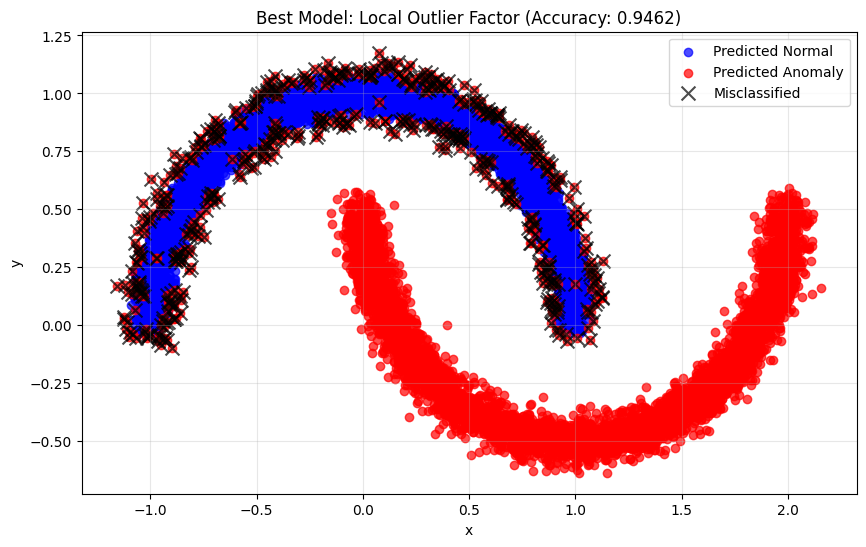

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (model_name, data) in enumerate(results.items()):
    y_pred = data["predictions"]
    
    # Plot points classified as normal (inliers)
    normal_points = X_test[y_pred == 1]
    axes[i].scatter(normal_points[:, 0], normal_points[:, 1], c='blue', alpha=0.7, label='Predicted Normal')
    
    # Plot points classified as anomalies (outliers)
    anomaly_points = X_test[y_pred == -1]
    axes[i].scatter(anomaly_points[:, 0], anomaly_points[:, 1], c='red', alpha=0.7, label='Predicted Anomaly')
    
    # Highlight misclassifications
    misclassified = X_test[test_ground_truth != y_pred]
    axes[i].scatter(misclassified[:, 0], misclassified[:, 1], c='black', marker='x', s=50, 
                alpha=0.7, label='Misclassified')
    
    axes[i].set_title(f"{model_name} (Acc: {results[model_name]['accuracy']:.4f})")
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("y")
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Now visualize the best model in more detail
plt.figure(figsize=(10, 6))
    
# Plot points classified as normal (inliers)
normal_points = X_test[best_predictions == 1]
plt.scatter(normal_points[:, 0], normal_points[:, 1], c='blue', alpha=0.7, label='Predicted Normal')

# Plot points classified as anomalies (outliers)
anomaly_points = X_test[best_predictions == -1]
plt.scatter(anomaly_points[:, 0], anomaly_points[:, 1], c='red', alpha=0.7, label='Predicted Anomaly')

# Highlight misclassifications
misclassified = X_test[test_ground_truth != best_predictions]
plt.scatter(misclassified[:, 0], misclassified[:, 1], c='black', marker='x', s=100, alpha=0.7, label='Misclassified')

plt.title(f"Best Model: {best_model_name} (Accuracy: {best_accuracy:.4f})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Fine-tune the best-performing model dynamically
print(f"Fine-tuning {best_model_name}...")

if best_model_name == "One-Class SVM":
    best_params = {"nu": 0.1, "gamma": 'auto'}
    best_accuracy = 0

    for nu in [0.01, 0.05, 0.1, 0.15, 0.2]:
        for gamma in ['auto', 'scale', 0.01, 0.1, 1.0]:
            model = OneClassSVM(gamma=gamma, nu=nu)
            model.fit(X_train)
            preds = model.predict(X_test)
            accuracy = accuracy_score(test_ground_truth, preds)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {"nu": nu, "gamma": gamma}

    print(f"Best {best_model_name} parameters: {best_params}")
    print(f"Best accuracy: {best_accuracy:.4f}")

    final_model = OneClassSVM(**best_params)

elif best_model_name == "Isolation Forest":
    best_params = {"n_estimators": 100, "max_samples": 'auto'}
    best_accuracy = 0

    for n_estimators in [50, 100, 200]:
        for max_samples in ['auto', 0.5, 0.8]:
            model = IsolationForest(n_estimators=n_estimators, max_samples=max_samples, random_state=42)
            model.fit(X_train)
            preds = model.predict(X_test)
            accuracy = accuracy_score(test_ground_truth, preds)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {"n_estimators": n_estimators, "max_samples": max_samples}

    print(f"Best {best_model_name} parameters: {best_params}")
    print(f"Best accuracy: {best_accuracy:.4f}")

    final_model = IsolationForest(**best_params, random_state=42)

elif best_model_name == "Local Outlier Factor":
    best_params = {"n_neighbors": 20, "contamination": 0.1}
    best_accuracy = 0

    for n_neighbors in [5, 10, 20, 30]:
        for contamination in [0.05, 0.1, 0.2]:
            model = LocalOutlierFactor(novelty=True, n_neighbors=n_neighbors, contamination=contamination)
            model.fit(X_train)
            preds = model.predict(X_test)
            accuracy = accuracy_score(test_ground_truth, preds)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {"n_neighbors": n_neighbors, "contamination": contamination}

    print(f"Best {best_model_name} parameters: {best_params}")
    print(f"Best accuracy: {best_accuracy:.4f}")

    final_model = LocalOutlierFactor(**best_params, novelty=True)

elif best_model_name == "Elliptic Envelope":
    best_params = {"contamination": 0.1}
    best_accuracy = 0

    for contamination in [0.05, 0.1, 0.2]:
        model = EllipticEnvelope(contamination=contamination, random_state=42)
        model.fit(X_train)
        preds = model.predict(X_test)
        accuracy = accuracy_score(test_ground_truth, preds)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {"contamination": contamination}

    print(f"Best {best_model_name} parameters: {best_params}")
    print(f"Best accuracy: {best_accuracy:.4f}")

    final_model = EllipticEnvelope(**best_params, random_state=42)

# Train and evaluate the final model
final_model.fit(X_train)
final_preds = final_model.predict(X_test)
final_accuracy = evaluate_model(test_ground_truth, final_preds, f"Optimized {best_model_name}")

Fine-tuning Local Outlier Factor...
Best Local Outlier Factor parameters: {'n_neighbors': 10, 'contamination': 0.05}
Best accuracy: 0.9738
Optimized Local Outlier Factor Accuracy: 0.9738
Optimized Local Outlier Factor Classification Report:
              precision    recall  f1-score   support

          -1       0.95      1.00      0.97      5000
           1       1.00      0.95      0.97      5000

    accuracy                           0.97     10000
   macro avg       0.98      0.97      0.97     10000
weighted avg       0.98      0.97      0.97     10000

Optimized Local Outlier Factor Confusion Matrix:
[[5000    0]
 [ 262 4738]]




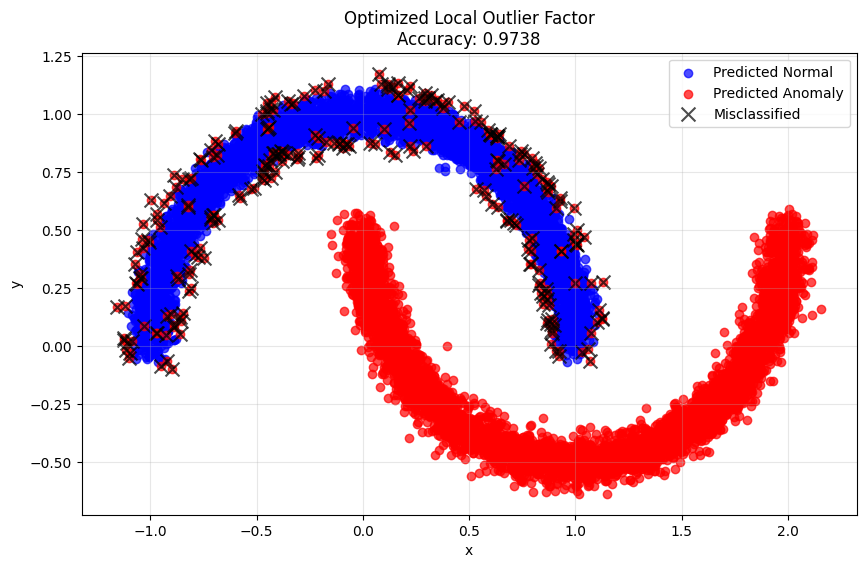

In [8]:
def plot_results(X_test, ground_truth, predictions, title, accuracy):
    plt.figure(figsize=(10, 6))
    
    # Plot points classified as normal (inliers)
    normal_points = X_test[predictions == 1]
    plt.scatter(normal_points[:, 0], normal_points[:, 1], c='blue', alpha=0.7, label='Predicted Normal')

    # Plot points classified as anomalies (outliers)
    anomaly_points = X_test[predictions == -1]
    plt.scatter(anomaly_points[:, 0], anomaly_points[:, 1], c='red', alpha=0.7, label='Predicted Anomaly')

    # Highlight misclassifications
    misclassified = X_test[ground_truth != predictions]
    plt.scatter(misclassified[:, 0], misclassified[:, 1], c='black', marker='x', s=100, alpha=0.7, label='Misclassified')

    plt.title(f"{title}\nAccuracy: {accuracy:.4f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_results(X_test, test_ground_truth, final_preds, f"Optimized {best_model_name}", final_accuracy)